#Import packages

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#Download dataset

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-01-10 23:08:48--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.195.128, 172.253.117.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2021-01-10 23:08:48 (142 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



#Load and visualize data

In [ ]:
#Function to plot the dataset
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

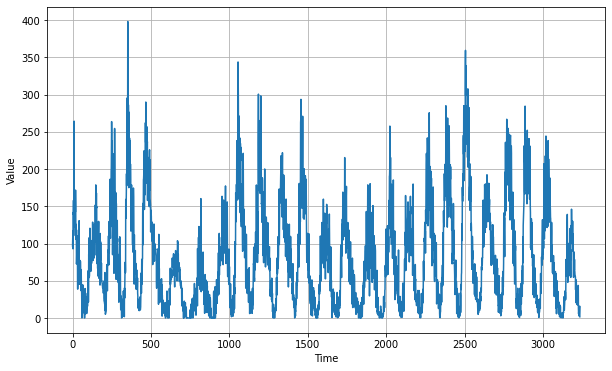

In [ ]:
#Read data from the csv file
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

#Data pre-processing

In [ ]:
#Train test split
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

shuffle_buffer_size = 1000


In [ ]:
#Segment data to windows
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
#Function used to forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

#Model Design

In [ ]:
#Set some random seeds to recreate the same results
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#Hyperparameters
window_size = 64
batch_size = 256 #If there is noise in the loss vs epoch plot, one of the good things to play with is the batch size.
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

#CNN and LSTM hybrid architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400) #Since the input is in the range of 1 to 400 that is why we multiply it with 400.
])

#Set a learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#Train the model and record the learning rate
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 10s 30ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 0s 30ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 0s 30ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 0s 29ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 1s 32ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 0s 30ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 0s 31ms/step - loss: 59.8144 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 0s 31ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 1s 32ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

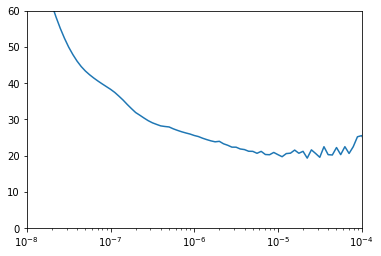

In [ ]:
#Plot loss against learning rate to see which learning rate is performing better
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
#Set some random seeds to recreate the same results
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

#Get the dataset
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

#Re-design the same model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

#Note that it is not always neccessary to work with numbers such as batch size, filters, window size being the power of 2
#They can be changed. e.g in this example training data is 3000 so if we change them to be divisible by 2 then we can see
#Some pretty interesting observations. Try experimenting with them in this way.

#Compile the model and set the optimal learning rate
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#Model training
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 16ms/step - loss: 47.7145 - mae: 48.2116
Epoch 2/500
30/30 [==============================] - 1s 16ms/step - loss: 26.8741 - mae: 27.3691
Epoch 3/500
30/30 [==============================] - 1s 16ms/step - loss: 22.9737 - mae: 23.4683
Epoch 4/500
30/30 [==============================] - 1s 16ms/step - loss: 20.2396 - mae: 20.7330
Epoch 5/500
30/30 [==============================] - 1s 16ms/step - loss: 19.1321 - mae: 19.6239
Epoch 6/500
30/30 [==============================] - 1s 17ms/step - loss: 18.8474 - mae: 19.3395
Epoch 7/500
30/30 [==============================] - 1s 16ms/step - loss: 19.6999 - mae: 20.1924
Epoch 8/500
30/30 [==============================] - 1s 17ms/step - loss: 18.6248 - mae: 19.1171
Epoch 9/500
30/30 [==============================] - 1s 16ms/step - loss: 18.2949 - mae: 18.7870
Epoch 10/500
30/30 [==============================] - 1s 16ms/step - loss: 19.4481 - mae: 19.9404
Epoch 11/500
30/30 [=========

#Model Evaluation

In [ ]:
#Perform forecast on test data
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

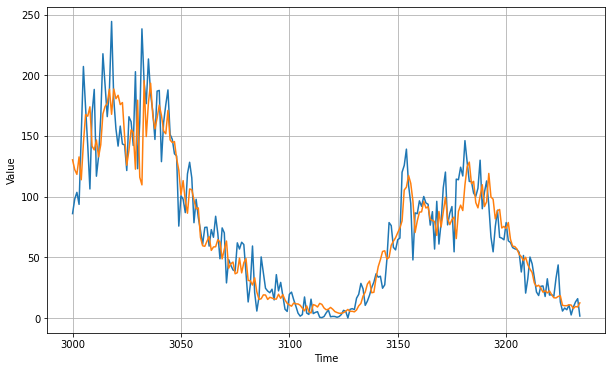

In [ ]:
#Visualize the true and forecasted data
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
#Calculate model mean absolute error
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.876089

<Figure size 432x288 with 0 Axes>

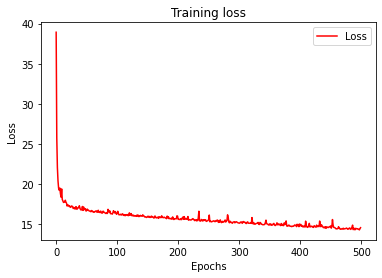

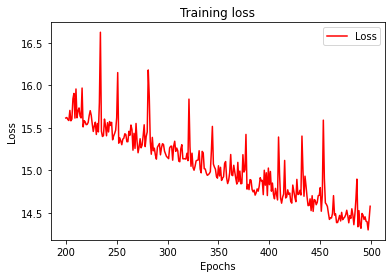

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()